In [23]:
import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Normal
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from helper import set_device, set_deterministic, build_dataloaders_cifar

In [43]:
class SparseDispatcher(object): 
    
    def __init__(self, num_experts, gates):
        # Intialize the dispatcher with the number of experts and the gates
        self._gates = gates
        self._num_experts = num_experts
        # sort experts
        sorted_experts, index_sorted_experts = torch.nonzero(gates).sort(0)
        _, self._expert_index = sorted_experts.split(1, dim=1)
        self._batch_index = torch.nonzero(gates)[index_sorted_experts[:, 1], 0]
        # calculate num samples that each expert gets
        self._part_sizes = (gates > 0).sum(0).tolist()
        # expand gates to match with self._batch_index
        gates_exp = gates[self._batch_index.flatten()]
        self._nonzero_gates = torch.gather(gates_exp, 1, self._expert_index)
        
    def dispatch(self, inp):
        """
        Creates one input tensor per expert.
        """
        
        inp_exp = inp[self._batch_index].squeeze(1)
        return torch.split(inp_exp, self._part_sizes, dim=0)
    
    
    def combine(self, expert_out, multiply_by_gates=True): 
        """
        Aggregates the outputs from the experts.
        """
        
        stiched = torch.cat(expert_out, dim=0)
        
        if multiply_by_gates:
            # Weight the outputs by the gates
            stiched = stiched.mul(self._nonzero_gates)
        
        # Create a tensor of zeros with the same size as the output of the experts to store the combined output
        zeros = torch.zeros(self._gates.size(0), expert_out[-1].size(1), requires_grad=True, device=stiched.device)
        # combine samples that have been processed by the same k experts
        combined = zeros.index_add(0, self._batch_index, stiched.float())
        
        return combined
    
    def expert_to_gates(self ): 
        return torch.split(self._nonzero_gates, self._part_sizes, dim=0)


        

In [45]:
class MultiLayerPerc(nn.Module): 
    def __init__(self, input_size, output_size, hidden_size): 
        super(MultiLayerPerc, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.ReLU(),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x): 
        return self.layer(x)

In [51]:
class MoE(nn.Module): 
    def __init__(self, input_size, output_size, hidden_size, num_expert, noisy_gating=True, k = 4):
        super(MoE, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.noisy_gating = noisy_gating
        self.num_expert = num_expert
        self.k = k
        
        self.expert = nn.ModuleList([MultiLayerPerc(self.input_size, self.output_size, self.hidden_size) for i in range(self.num_expert)])
        self.w_gates = nn.Parameter(torch.zeros(self.input_size, self.num_expert), requires_grad=True)
        self.w_noise = nn.Parameter(torch.zeros(self.input_size, self.num_expert), requires_grad=True)
        
        self.softplus = nn.Softplus()
        self.softmax = nn.Softmax(dim=1)
        self.register_buffer("mean", torch.tensor([0.0]))
        self.register_buffer("std", torch.tensor([1.0]))
        
        assert (self.k <= self.num_expert)
        
    def cv_squared(self, x):
        """
        Coefficient of variation squared
        """
        eps = 1e-10
        
        if x.shape[0] == 1:
            return torch.tensor([0], device = x.device, dtype= x.dtype)
        
        return x.float().var() / (x.float().mean()**2 + eps)
    
    def _gates_to_load(self, gates): 
        
        return torch.sum(gates > 0, dim=0)
    
    def _prob_in_top_k(self, clean_values, noisy_values, noise_stddev, noisy_top_values):
        
        batch = clean_values.size(0)
        m = noisy_top_values.size(1)
        top_values_flat = noisy_top_values.flatten()
        
        threshold_positions_if_in = torch.arange(batch, device =clean_values.device) * m + self.k 
        threshold_if_in = torch.unsqueeze(torch.gather(top_values_flat, 0, threshold_positions_if_in), 1)
        is_in = torch.gt(noisy_values, threshold_if_in)
        threshold_positions_if_out = threshold_positions_if_in - 1
        threshold_if_out = torch.unsqueeze(torch.gather(top_values_flat, 0, threshold_positions_if_out), 1)
        # is each value currently in the top k.
        normal = Normal(self.mean, self.std)
        prob_if_in = normal.cdf((clean_values - threshold_if_in)/noise_stddev)
        prob_if_out = normal.cdf((clean_values - threshold_if_out)/noise_stddev)
        
        prob = torch.where(is_in, prob_if_in, prob_if_out)
        return prob
    
    def noisy_top_k_gating(self, x, train, noise_eps = 1e-2): 
        
        clean_logits = torch.matmul(x, self.w_gates)
        if self.noisy_gating and train: 
            raw_noise_stdev = x @ self.w_noise
            noise_stdev = ((self.softplus(raw_noise_stdev) + noise_eps))
            noisy_logits = clean_logits + (torch.randn_like(clean_logits) * noise_stdev) 
            logits = noisy_logits
        else:
            logits = clean_logits
            
        
        top_logits, top_indices = logits.topk(min(self.k + 1 , self.num_expert), dim=1)
        top_k_logits = top_logits[:, :self.k]
        top_k_indices = top_indices[:, :self.k]
        top_k_gate = self.softmax(top_k_logits)
        
        zeros = torch.zeros_like(logits, requires_grad=True)
        gates = zeros.scatter(1, top_k_indices, top_k_gate)
        
        if self.noisy_gating and self.k < self.num_expert and train: 
            load = (self._prob_in_top_k(clean_logits, noisy_logits, noise_stdev, top_logits)).sum(0)
        else:
            load = self._gates_to_load(gates)
            
        return gates, load
    
    
    def forward(self, x, loss_coef = 1e-2): 
        
        gates, load = self.noisy_top_k_gating(x, self.training)
        importance = gates.sum(0)
        
        loss = self.cv_squared(importance) + loss_coef * self.cv_squared(load)
        loss *= loss_coef 
        
        dispatcher = SparseDispatcher(self.num_expert, gates)
        expert_in = dispatcher.dispatch(x)
        gates = dispatcher.expert_to_gates()
        
        expert_out = [self.expert[i](expert_in[i]) for i in range(self.num_expert)]
        y = dispatcher.combine(expert_out)
        
        return y, loss
        
        
        

In [7]:
device = set_device()
set_deterministic()

PyTorch version: 2.2.2
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps
Set deterministic behavior


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [10]:
train_dataloader, test_dataloader, test_dataset_viz, class_names = build_dataloaders_cifar(
                                                                                        data_path='../../data', 
                                                                                        train_transforms=transform,
                                                                                        test_transforms=transform,
                                                                                        batch_size=64,
                                                                                        num_workers=10)


len(train_dataloader), len(test_dataloader), class_names

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


(782,
 157,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [52]:
model = MoE(input_size = 3072, output_size = 10, hidden_size = 128, num_expert = 10, noisy_gating = True,  k = 4)
model.to(device)
model

MoE(
  (expert): ModuleList(
    (0-9): 10 x MultiLayerPerc(
      (layer): Sequential(
        (0): Linear(in_features=3072, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=10, bias=True)
        (3): ReLU()
        (4): Softmax(dim=1)
      )
    )
  )
  (softplus): Softplus(beta=1, threshold=20)
  (softmax): Softmax(dim=1)
)

In [29]:
paramaters = model.parameters()
print(sum(p.numel() for p in paramaters))

1639976


In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()

for epoch in range(3): 
    
    running_loss = 0.0
    loss_i = []
    for i, data in enumerate(train_dataloader, 0): 
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        inputs = inputs.view(inputs.shape[0], -1)
        outputs, aux_loss = model(inputs)
        loss = criterion(outputs, labels) + aux_loss
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 200 == 199: 
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 200}")
            running_loss = 0.0
            
        loss_i.append(loss.item())
            
print("Finished Training")



Epoch: 1, Batch: 200, Loss: 2.061523683667183
Epoch: 1, Batch: 400, Loss: 2.05779194355011
Epoch: 1, Batch: 600, Loss: 2.0687936210632323
Epoch: 2, Batch: 200, Loss: 2.045137097835541
Epoch: 2, Batch: 400, Loss: 2.0466869968175887
Epoch: 2, Batch: 600, Loss: 2.046202701330185
Epoch: 3, Batch: 200, Loss: 2.038960137963295
Epoch: 3, Batch: 400, Loss: 2.035447992682457
Epoch: 3, Batch: 600, Loss: 2.0331110072135927
Finished Training


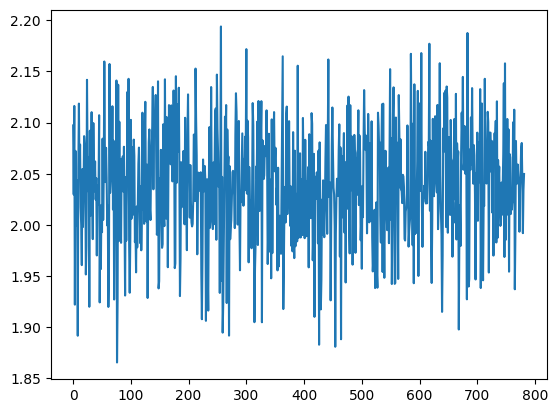

In [59]:
import matplotlib.pyplot as plt
plt.plot(loss_i)

In [60]:
correct = 0 
total = 0 
model.eval()
with torch.no_grad(): 
    for data in test_dataloader: 
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(inputs.shape[0], -1)
        outputs, _ = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}")

Accuracy of the network on the 10000 test images: 41.01
